In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time, pickle, gzip
import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 

'''Algos'''
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [2]:
# Load the datasets
current_path = os.getcwd()
file = '/datasets/mnist_data/mnist.pkl.gz'

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [3]:
# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [4]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train), \
                         len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [5]:
# Describe the training matrix
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [6]:
# Show the labels
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [7]:
def view_digit(example):
    label = y_train.loc[example]
    image = X_train.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

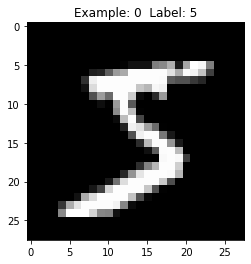

In [8]:
# View the first digit
view_digit(0)

In [9]:
def one_hot(series):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(series)+1))
    return label_binarizer.transform(series)

In [10]:
def reverse_one_hot(originalSeries, newSeries):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(originalSeries)+1))
    return label_binarizer.inverse_transform(newSeries)

In [11]:
# Create one-hot vectors for the labels
y_train_oneHot = one_hot(y_train)
y_validation_oneHot = one_hot(y_validation)
y_test_oneHot = one_hot(y_test)

In [12]:
# Show one-hot vector for example 0, which is the number 5
y_train_oneHot[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [13]:
# Classification Model using TensorFlow
x_train, x_test = np.reshape(X_train.values, (50000,28,28))/ 255.0, np.reshape(X_test.values, (10000,28,28)) / 255.0

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

W0724 13:12:22.485005 4487284160 deprecation.py:506] From /Users/ankurpatel/anaconda3/envs/unsupervised-tf-1.14/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [16]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=10, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 65us/sample - loss: 1.3714 - acc: 0.6464 - val_loss: 0.7280 - val_acc: 0.8277
Epoch 2/10
50000/50000 [==============================] - 3s 62us/sample - loss: 0.6328 - acc: 0.8262 - val_loss: 0.4765 - val_acc: 0.8784
Epoch 3/10
50000/50000 [==============================] - 3s 60us/sample - loss: 0.4852 - acc: 0.8632 - val_loss: 0.3903 - val_acc: 0.8965
Epoch 4/10
50000/50000 [==============================] - 3s 60us/sample - loss: 0.4231 - acc: 0.8797 - val_loss: 0.3488 - val_acc: 0.9041
Epoch 5/10
50000/50000 [==============================] - 3s 62us/sample - loss: 0.3857 - acc: 0.8890 - val_loss: 0.3210 - val_acc: 0.9106
Epoch 6/10
50000/50000 [==============================] - 3s 61us/sample - loss: 0.3599 - acc: 0.8955 - val_loss: 0.3028 - val_acc: 0.9129
Epoch 7/10
50000/50000 [==============================] - 3s 63us/sample - loss: 0.3400 - acc: 0.9023 - val_loss: 0.

In [17]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [13]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 784
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [14]:
# Percentage of Variance Captured by 784 principal components
print("Variance Explained by all 784 principal components: ", \
      sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  0.9999999999999997


In [15]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 100 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:99].sum(axis=1).values)
print('Variance Captured by First 200 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:199].sum(axis=1).values)
print('Variance Captured by First 300 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:299].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.48876238]
Variance Captured by First 20 Principal Components:  [0.64398025]
Variance Captured by First 50 Principal Components:  [0.8248609]
Variance Captured by First 100 Principal Components:  [0.91465857]
Variance Captured by First 200 Principal Components:  [0.96650076]
Variance Captured by First 300 Principal Components:  [0.9862489]


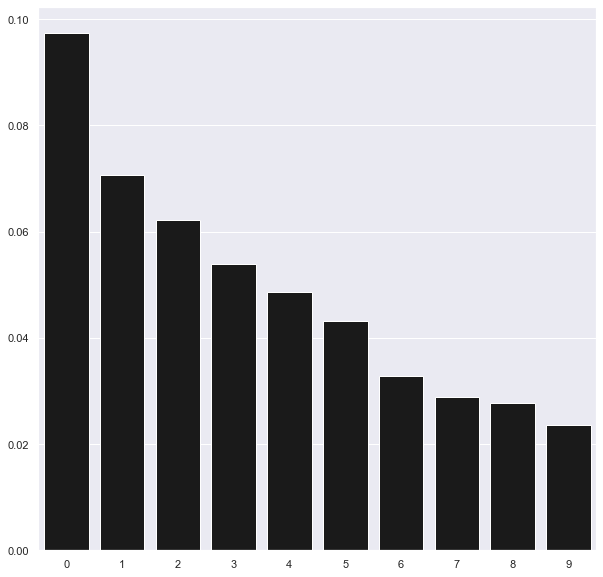

In [16]:
sns.set(rc={'figure.figsize':(10,10)})
sns.barplot(data=importanceOfPrincipalComponents.loc[:,0:9],color='k')

In [17]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

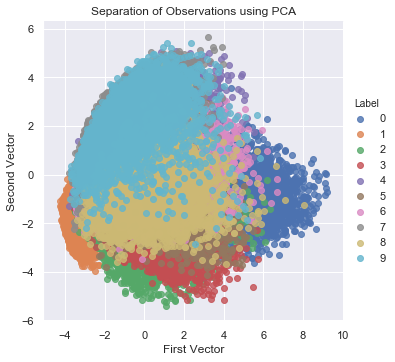

In [18]:
scatterPlot(X_train_PCA, y_train, "PCA")

Text(0.5, 1, 'Separation of Observations Using Original Feature Set')

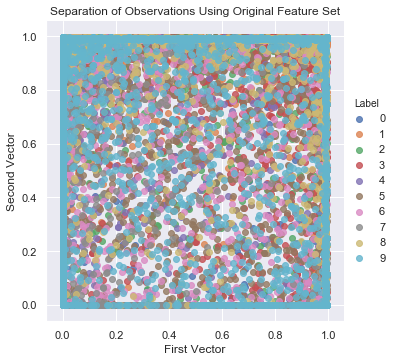

In [19]:
X_train_scatter = pd.DataFrame(data=X_train.loc[:,[350,406]], index=X_train.index)
X_train_scatter = pd.concat((X_train_scatter,y_train), axis=1, join="inner")
X_train_scatter.columns = ["First Vector", "Second Vector", "Label"]
sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=X_train_scatter, fit_reg=False)
ax = plt.gca()
ax.set_title("Separation of Observations Using Original Feature Set")

In [28]:
# TensorBoard
print(current_path)

/Users/ankurpatel/Documents/handson-unsupervised-learning


In [38]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
log_dir = current_path+"/logs/"
!mkdir ./logs/
X_train_PCA.to_csv(log_dir+'data.tsv', sep = '\t', index=False)
y_train.to_csv(log_dir+'labels.tsv', sep = '\t', index=False, header=False)

In [47]:
tf.reset_default_graph()
# TensorFlow Variable from data
df_pca = X_train_PCA.values
embedding_var = tf.Variable(df_pca, name="PCA")
summary_writer = tf.summary.FileWriter(log_dir)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
metadata_path =  log_dir+"labels.tsv"
embedding.metadata_path = metadata_path

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

In [48]:
checkpoint = log_dir + "model.ckpt"
with tf.Session() as sess:
    saver = tf.train.Saver([embedding_var])
    sess.run(embedding_var.initializer)
    saver.save(sess, checkpoint)

In [ ]:
!tensorboard --logdir=/Users/ankurpatel/Documents/handson-unsupervised-learning/logs --port=8088

TensorBoard 1.14.0 at http://Ankurs-MacBook-Pro.local:8088/ (Press CTRL+C to quit)
I0724 15:25:31.333765 123145520631808 _internal.py:122] ::ffff:25.208.54.74 - - [24/Jul/2019 15:25:31] "GET /data/plugins_listing HTTP/1.1" 200 -
I0724 15:25:31.334629 123145546907648 _internal.py:122] ::ffff:25.208.54.74 - - [24/Jul/2019 15:25:31] "GET /data/experiments HTTP/1.1" 200 -
I0724 15:25:31.335344 123145536397312 _internal.py:122] ::ffff:25.208.54.74 - - [24/Jul/2019 15:25:31] "GET /data/runs HTTP/1.1" 200 -
I0724 15:25:31.335847 123145531142144 _internal.py:122] ::ffff:25.208.54.74 - - [24/Jul/2019 15:25:31] "GET /data/environment HTTP/1.1" 200 -
I0724 15:25:31.337773 123145541652480 _internal.py:122] ::ffff:25.208.54.74 - - [24/Jul/2019 15:25:31] "GET /font-roboto/oMMgfZMQthOryQo9n22dcuvvDin1pK8aKteLpeZ5c0A.woff2 HTTP/1.1" 200 -
I0724 15:25:31.338357 123145536397312 _internal.py:122] ::ffff:25.208.54.74 - - [24/Jul/2019 15:25:31] "GET / HTTP/1.1" 200 -
I0724 15:25:31.338828 123145546907648 _

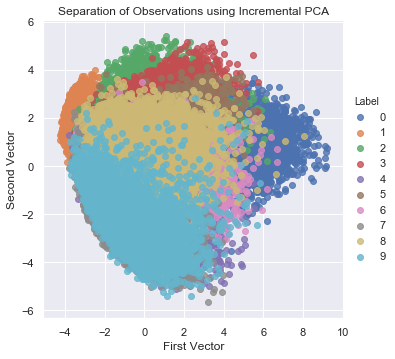

In [26]:
# Incremental PCA
from sklearn.decomposition import IncrementalPCA

n_components = 784
batch_size = None

incrementalPCA = IncrementalPCA(n_components=n_components, \
                                batch_size=batch_size)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = \
    pd.DataFrame(data=X_train_incrementalPCA, index=train_index)

X_validation_incrementalPCA = incrementalPCA.transform(X_validation)
X_validation_incrementalPCA = \
    pd.DataFrame(data=X_validation_incrementalPCA, index=validation_index)

scatterPlot(X_train_incrementalPCA, y_train, "Incremental PCA")

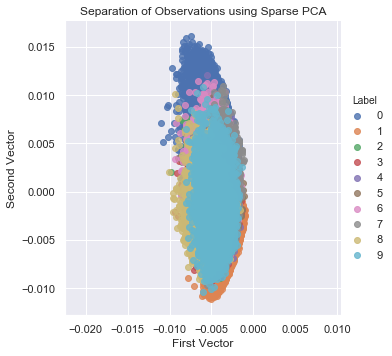

In [43]:
# Sparse PCA
from sklearn.decomposition import SparsePCA

n_components = 100
alpha = 0.0001
random_state = 2018
n_jobs = -1

sparsePCA = SparsePCA(n_components=n_components, \
                alpha=alpha, random_state=random_state, n_jobs=n_jobs)

sparsePCA.fit(X_train.loc[:10000,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=train_index)

X_validation_sparsePCA = sparsePCA.transform(X_validation)
X_validation_sparsePCA = \
    pd.DataFrame(data=X_validation_sparsePCA, index=validation_index)

scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

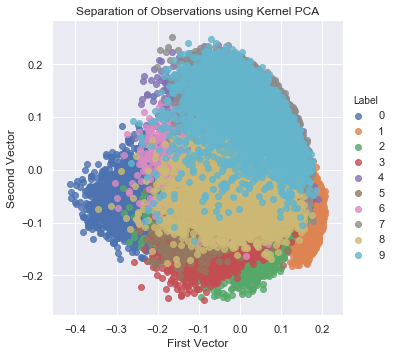

In [44]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 100
kernel = 'rbf'
gamma = None
random_state = 2018
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                      gamma=gamma, n_jobs=n_jobs, random_state=random_state)

kernelPCA.fit(X_train.loc[:10000,:])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA,index=train_index)

X_validation_kernelPCA = kernelPCA.transform(X_validation)
X_validation_kernelPCA = \
    pd.DataFrame(data=X_validation_kernelPCA, index=validation_index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

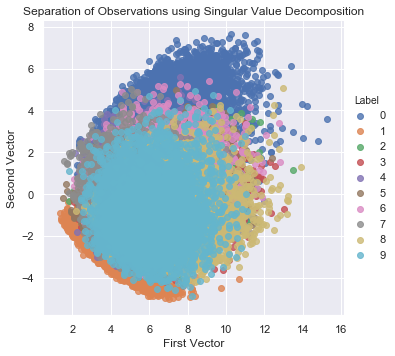

In [45]:
# Singular Value Decomposition
from sklearn.decomposition import TruncatedSVD

n_components = 200
algorithm = 'randomized'
n_iter = 5
random_state = 2018

svd = TruncatedSVD(n_components=n_components, algorithm=algorithm, \
                   n_iter=n_iter, random_state=random_state)

X_train_svd = svd.fit_transform(X_train)
X_train_svd = pd.DataFrame(data=X_train_svd, index=train_index)

X_validation_svd = svd.transform(X_validation)
X_validation_svd = pd.DataFrame(data=X_validation_svd, index=validation_index)

scatterPlot(X_train_svd, y_train, "Singular Value Decomposition")

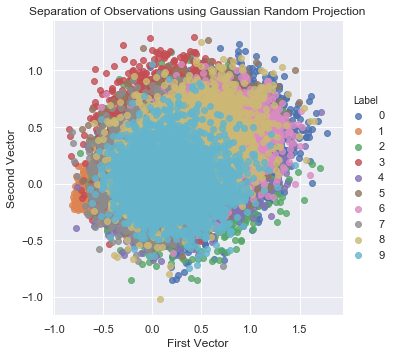

In [46]:
# Gaussian Random Projection
from sklearn.random_projection import GaussianRandomProjection

n_components = 'auto'
eps = 0.5
random_state = 2018

GRP = GaussianRandomProjection(n_components=n_components, eps=eps, \
                               random_state=random_state)

X_train_GRP = GRP.fit_transform(X_train)
X_train_GRP = pd.DataFrame(data=X_train_GRP, index=train_index)

X_validation_GRP = GRP.transform(X_validation)
X_validation_GRP = pd.DataFrame(data=X_validation_GRP, index=validation_index)

scatterPlot(X_train_GRP, y_train, "Gaussian Random Projection")

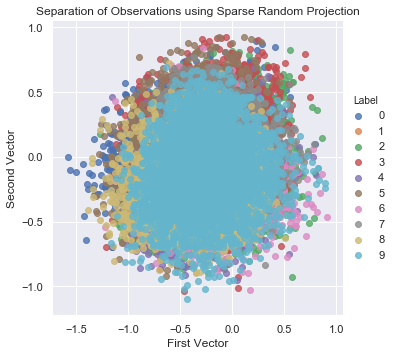

In [47]:
# Sparse Random Projection
from sklearn.random_projection import SparseRandomProjection

n_components = 'auto'
density = 'auto'
eps = 0.5
dense_output = False
random_state = 2018

SRP = SparseRandomProjection(n_components=n_components, \
        density=density, eps=eps, dense_output=dense_output, \
        random_state=random_state)

X_train_SRP = SRP.fit_transform(X_train)
X_train_SRP = pd.DataFrame(data=X_train_SRP, index=train_index)

X_validation_SRP = SRP.transform(X_validation)
X_validation_SRP = pd.DataFrame(data=X_validation_SRP, index=validation_index)

scatterPlot(X_train_SRP, y_train, "Sparse Random Projection")

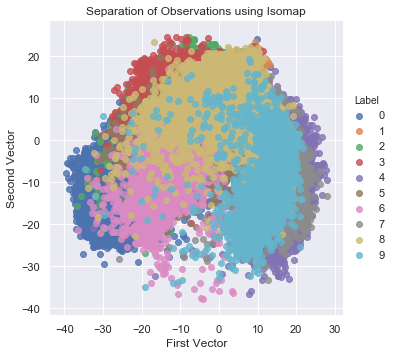

In [48]:
# Isomap

from sklearn.manifold import Isomap

n_neighbors = 5
n_components = 10
n_jobs = 4

isomap = Isomap(n_neighbors=n_neighbors, \
                n_components=n_components, n_jobs=n_jobs)

isomap.fit(X_train.loc[0:5000,:])
X_train_isomap = isomap.transform(X_train)
X_train_isomap = pd.DataFrame(data=X_train_isomap, index=train_index)

X_validation_isomap = isomap.transform(X_validation)
X_validation_isomap = pd.DataFrame(data=X_validation_isomap, \
                                   index=validation_index)

scatterPlot(X_train_isomap, y_train, "Isomap")

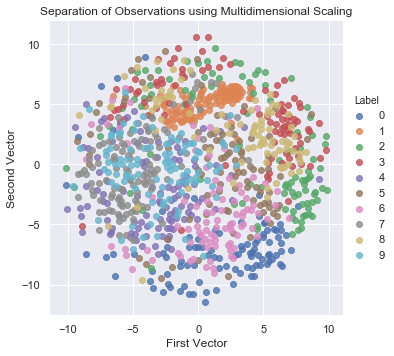

In [49]:
# Multidimensional Scaling
from sklearn.manifold import MDS

n_components = 2
n_init = 12
max_iter = 1200
metric = True
n_jobs = 4
random_state = 2018

mds = MDS(n_components=n_components, n_init=n_init, max_iter=max_iter, \
          metric=metric, n_jobs=n_jobs, random_state=random_state)

X_train_mds = mds.fit_transform(X_train.loc[0:1000,:])
X_train_mds = pd.DataFrame(data=X_train_mds, index=train_index[0:1001])

scatterPlot(X_train_mds, y_train, "Multidimensional Scaling")

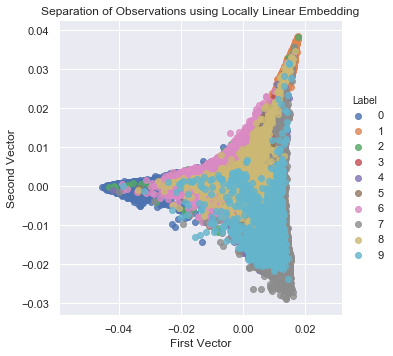

In [50]:
# Locally Linear Embedding (LLE)
from sklearn.manifold import LocallyLinearEmbedding

n_neighbors = 10
n_components = 2
method = 'modified'
n_jobs = 4
random_state = 2018

lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, \
        n_components=n_components, method=method, \
        random_state=random_state, n_jobs=n_jobs)

lle.fit(X_train.loc[0:5000,:])
X_train_lle = lle.transform(X_train)
X_train_lle = pd.DataFrame(data=X_train_lle, index=train_index)

X_validation_lle = lle.transform(X_validation)
X_validation_lle = pd.DataFrame(data=X_validation_lle, index=validation_index)

scatterPlot(X_train_lle, y_train, "Locally Linear Embedding")

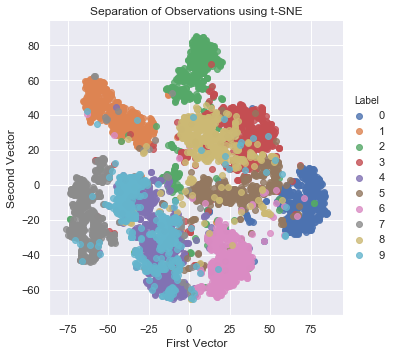

In [51]:
# t-SNE
from sklearn.manifold import TSNE

n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'
random_state = 2018

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate, \
            perplexity=perplexity, early_exaggeration=early_exaggeration, \
            init=init, random_state=random_state)

X_train_tSNE = tSNE.fit_transform(X_train_PCA.loc[:5000,:9])
X_train_tSNE = pd.DataFrame(data=X_train_tSNE, index=train_index[:5001])

scatterPlot(X_train_tSNE, y_train, "t-SNE")

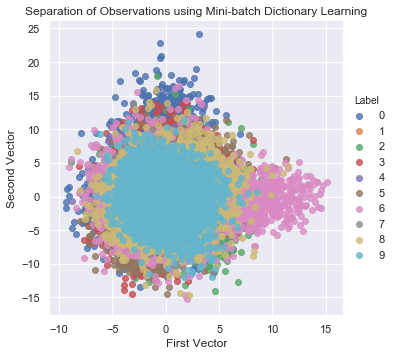

In [52]:
# Mini-batch dictionary learning
from sklearn.decomposition import MiniBatchDictionaryLearning

n_components = 50
alpha = 1
batch_size = 200
n_iter = 25
random_state = 2018

miniBatchDictLearning = MiniBatchDictionaryLearning( \
                        n_components=n_components, alpha=alpha, \
                        batch_size=batch_size, n_iter=n_iter, \
                        random_state=random_state)

miniBatchDictLearning.fit(X_train.loc[:,:10000])
X_train_miniBatchDictLearning = miniBatchDictLearning.fit_transform(X_train)
X_train_miniBatchDictLearning = pd.DataFrame( \
    data=X_train_miniBatchDictLearning, index=train_index)

X_validation_miniBatchDictLearning = \
    miniBatchDictLearning.transform(X_validation)
X_validation_miniBatchDictLearning = \
    pd.DataFrame(data=X_validation_miniBatchDictLearning, \
    index=validation_index)

scatterPlot(X_train_miniBatchDictLearning, y_train, \
            "Mini-batch Dictionary Learning")

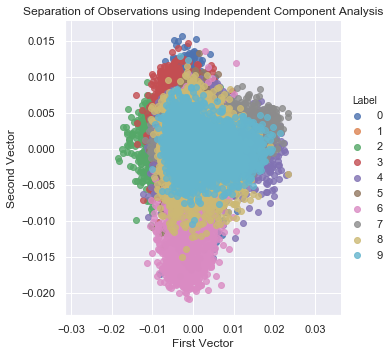

In [53]:
# Independent Component Analysis
from sklearn.decomposition import FastICA

n_components = 25
algorithm = 'parallel'
whiten = True
max_iter = 100
random_state = 2018

fastICA = FastICA(n_components=n_components, algorithm=algorithm, \
                  whiten=whiten, max_iter=max_iter, random_state=random_state)

X_train_fastICA = fastICA.fit_transform(X_train)
X_train_fastICA = pd.DataFrame(data=X_train_fastICA, index=train_index)

X_validation_fastICA = fastICA.transform(X_validation)
X_validation_fastICA = pd.DataFrame(data=X_validation_fastICA, \
                                    index=validation_index)

scatterPlot(X_train_fastICA, y_train, "Independent Component Analysis")